In [ ]:
!pip install ortools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.4.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21

In [ ]:
import numpy as np
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def finite_IRL(P, policy, gamma, l1, R_max):
    k = P.shape[0]
    N = P.shape[1]
    actions = set(range(k))

    def dot(a, s):
        return (P[policy[s], s] - P[a, s]) @ np.linalg.inv(np.eye(N) - gamma * P[policy[s]])

    solver = pywraplp.Solver.CreateSolver('GLOP')

    Z = []
    R = []
    abs_R = []
    for s in range(N):
        # Add the new Z variables and R variable here
        tmp_z = solver.NumVar(-solver.infinity(), solver.infinity(), f"Z{s}")
        tmp_r = solver.NumVar(-R_max, R_max, f"R{s}")
        tmp_abs_r = solver.NumVar(-R_max, R_max, f"absR{s}")
        Z.append(tmp_z)
        R.append(tmp_r)
        abs_R.append(tmp_abs_r)


    # Define the optimization here
    objective = solver.Objective()
    for i in range(N):
        objective.SetCoefficient(Z[i], 1)
        objective.SetCoefficient(R[i], 0)
        objective.SetCoefficient(abs_R[i], -l1)
    objective.SetMaximization()

    for i in range(N):
        solver.Add(abs_R[i] >= R[i])
        solver.Add(abs_R[i] >= -R[i])

    for s in range(N):
        for a in actions - {policy[s]}:
            # Add 1st set and 2nd set of constraints here

            tmp_coeff = dot(a,s)
            constraint1 = solver.Constraint(-solver.infinity(), 0)
            for i in range(N):
                constraint1.SetCoefficient(R[i], -tmp_coeff[i])

            constraint2 = solver.Constraint(-solver.infinity(), 0)
            for i in range(N):
                constraint2.SetCoefficient(R[i], -tmp_coeff[i])
            constraint2.SetCoefficient(Z[s], 1)


    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        # Retrieve solution
        solution = [R[i].solution_value() for i in range(N)]
        optimal_value = solver.Objective().Value()
        return solution, optimal_value
    else:
        return None, None

In [ ]:
def find_lambda(P, policy, gamma, h, R_max):
    lo = 0
    hi = h

    n = 0
    while lo < hi:
        mid = (lo + hi)/2
        r, v = finite_IRL(P, policy, gamma, mid, R_max)
        r = np.array(r)
        if sum(r) < 1e-10:
            hi = mid
        else:
            lo = mid

        n += 1
        if n > 1e4:
            break

    return mid

In [ ]:
def create_P(n):
    poss_n_act = {}
    poss_n_act[0] = 3
    poss_n_act[n*(n-1)] = 3
    for i in range(1,n-1):
        poss_n_act[i] = 4
        poss_n_act[n*(n-1)+i] = 4
    poss_n_act[n-1] = 3
    poss_n_act[n**2 - 1] = 1

    for i in range(n,n*(n-1),n):
        poss_n_act[i] = 4
        for j in range(1,n-1):
            poss_n_act[i+j] = 5
        poss_n_act[i+n-1] = 4

    P = np.zeros((5,n**2,n**2))

    for i in range(n**2):
        P[4][i][i] = 1/poss_n_act[i]

    # Up
    for i in range(n*(n-1)):
        P[0][i][i+n] = 1/poss_n_act[i]

    # Right
    for i in range(n**2-1):
        if (i + 1)%n != 0:
            P[1][i][i+1] = 1/poss_n_act[i]

    # Down
    for i in range(n,n**2-1):
        P[2][i][i-n] = 1/poss_n_act[i]

    # left
    for i in range(n**2-1):
        if i%n != 0:
            P[3][i][i-1] = 1/poss_n_act[i]

    return P

In [ ]:
def bellman_eq(V, T, R, gamma, state, action):
    # Initialize the value of the Bellman equation
    num_state = V.shape[0]
    val = 0

    # Compute the value of the Bellman equation for the given state-action pair
    for i in range(num_state):
        val += T[state, action, i] * (R[state, action, i] + gamma*V[i])

    return val

def value_iteration(T, R, gamma):
    # Initialize value functions V_now and V_last
    num_state = T.shape[0]
    num_action = T.shape[1]
    V_now = np.zeros(num_state)
    V_last = np.zeros(num_state)

    while True:
        # Update V_last with the current values of V_now
        V_last = np.copy(V_now)

        # Update V_now for each state using the Bellman optimality equation
        for s in range(num_state):
            max_val = float('-inf')
            # Find the maximum value over all actions for the current state
            for a in range(num_action):
                max_val = max(max_val, bellman_eq(V_last, T, R, gamma, s, a))
            # Update V_now for the current state
            V_now[s] = max_val

        # Check for convergence
        if np.allclose(V_now, V_last):
            break

    return V_now


def Q_star(V_star, T, R, gamma):
    num_state = T.shape[0]
    num_action = T.shape[1]
    # Initialize a matrix to store Q-values for all state-action pairs
    Q_s = np.zeros((num_state, num_action))

    # Compute Q-values for each state-action pair
    for a in range(num_action):
        for s in range(num_state):
            # Compute the Q-value using the Bellman equation and store it in Q_s
            Q_s[s][a] += bellman_eq(V_star, T, R, gamma, s, a)

    # Return the matrix of Q-values
    return Q_s

def optimal_policy(Q_star):
    num_state = Q_star.shape[0]
    # Initialize an empty list to store the optimal policy
    policy = []

    # Iterate over all states
    for s in range(num_state):
        # Find the index of the action with the highest Q-value for the current state
        optimal_action = np.argmax(Q_star[s])

        # Append the optimal action to the policy list
        policy.append(optimal_action)

    # Return the optimal policy
    return policy

In [ ]:
P5 = create_P(5)
R = np.zeros((25,5,25))
R[24] = np.ones((5,25))
T = np.transpose(P5, (1,0,2))
gamma = 0.85
V = value_iteration(T, R, gamma)
Q = Q_star(V, T, R, gamma)
opt_pol = optimal_policy(Q)
opt_pol

[0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 4]

In [ ]:
l1 = find_lambda(P5, opt_pol, gamma, 100, 1)

NameError: name 'find_lambda' is not defined

In [ ]:
l1

5.910564988731634

In [ ]:
r, v = finite_IRL(P5, opt_pol, gamma, 5.91, 1)

In [ ]:
r

[0.0,
 2.220446049250313e-16,
 -2.220446049250313e-16,
 0.0,
 -2.220446049250313e-16,
 2.220446049250313e-16,
 0.0,
 0.0,
 0.0,
 0.0,
 -2.220446049250313e-16,
 0.0,
 1.1102230246251565e-16,
 0.0,
 0.0,
 2.220446049250313e-16,
 0.0,
 0.0,
 0.0,
 -0.21249999999999747,
 1.1102230246251565e-16,
 2.220446049250313e-16,
 0.0,
 2.4424906541753444e-15,
 1.0]

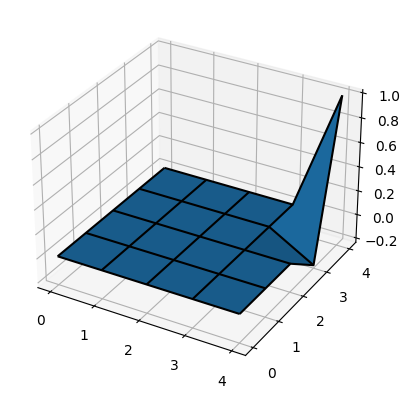

In [ ]:
x = np.array(range(5))
y = np.array(range(5))
X,Y = np.meshgrid(x,y)

Z = np.array(r).reshape(5,5)

fig = plt.figure()
axes = fig.add_subplot(projection ='3d')
axes.plot_surface(X, Y, Z)
axes.plot_wireframe(X, Y, Z, color='black')

plt.show()